In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [4]:
pwd

'/content/drive/MyDrive/Colab Notebooks'

In [5]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 40.1 MB/s eta 0:00:00


In [6]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, concatenate, Activation, LeakyReLU,BatchNormalization,Conv2D,add
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,SGD,Adagrad
from keras.models import Model, load_model
from keras.layers import Input,Dropout,add,BatchNormalization
import numpy as np
from tensorflow.keras.initializers import GlorotNormal,HeNormal,RandomNormal
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, UpSampling2D, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal,Orthogonal
from tensorflow.keras.regularizers import l2
from tensorflow_addons.layers import SpectralNormalization,InstanceNormalization
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
tf.keras.backend.clear_session()
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = InteractiveSession(config=ConfigProto(gpu_options=gpu_options))
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
/usr/local/lib/python3.9/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [7]:
FFHQ_DIR=r'data/FFHQ_data_min'
FFHQ_read = open(FFHQ_DIR, "rb")
FFHQ_data = pickle.load(FFHQ_read)
np.random.shuffle(FFHQ_data)
# FFHQ_data=FFHQ_data[:2000,:,:,:]
# np.random.shuffle(FFHQ_data)

In [8]:
FFHQ_data.shape

(1000, 224, 224, 3)

In [9]:
IMG_SIZE=128
def preprocess_image(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image= image.numpy().astype(np.float32)
    return image
new_image = (tf.cast(FFHQ_data, tf.float32) / 127.5)-1
new_image=preprocess_image(new_image)

(1000, 128, 128, 3)


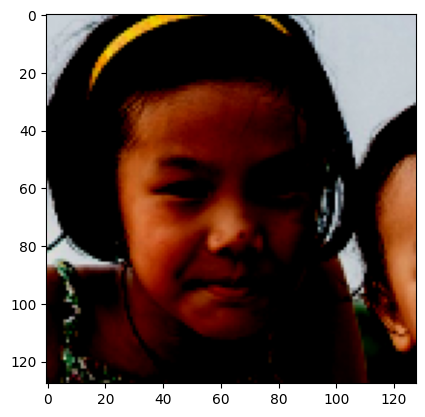

In [10]:
plt.imshow(new_image[3])
print(new_image.shape)

In [11]:

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


def cutmix(train_ds_one, train_ds_two):
    image1,image2 = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)
    return image

In [12]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [13]:
from keras.layers.serialization import activation
from tensorflow.python import training
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input,Dropout,add,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import keras
import tensorflow as tf
class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset
def make_generator_model():
    inputs = Input(shape=(100,))
    den1 = Dense(128*128*3)(inputs)
    den1 = Reshape((128,128, 3))(den1)

    conv1 = keras.layers.Conv2D(16, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(den1)

    conv2 = keras.layers.Conv2D(32, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(conv1)
    conv2=BatchNormalization()(conv2)

    conv3 = keras.layers.Conv2D(64, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(conv2)
    conv3 = BatchNormalization()(conv3)

    conv4 = keras.layers.Conv2D(128, 3, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(conv3)
    conv4 = BatchNormalization()(conv4)

    up7 = keras.layers.Conv2DTranspose(64, 2, activation=tf.keras.layers.ReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(conv4)
    up7=Dropout(0.5)(up7)
    merge7 = keras.layers.concatenate([conv3, up7], axis=3)

    up8 = keras.layers.Conv2DTranspose(32, 4,2, activation=tf.keras.layers.ReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(merge7)
    up8=Dropout(0.5)(up8)
    merge8 = keras.layers.concatenate([conv2, up8], axis=3)
    

    up9 = keras.layers.Conv2DTranspose(16, 4, activation=tf.keras.layers.ReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(merge8)
    up9=Dropout(0.5)(up9)
    merge9 = keras.layers.concatenate([conv1, up9], axis=3)

    conv9 = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,padding='same', kernel_initializer='he_normal',activation=tf.keras.layers.ReLU())(merge9)  # (bs, 256, 256, 3)
    conv9=keras.layers.Conv2D(128, (4,4), padding='same')(conv9)
    conv9=LeakyReLU(alpha=0.2)(conv9)
    conv9=keras.layers.Conv2D(128, (4,4), padding='same')(conv9)
    conv9=LeakyReLU(alpha=0.2)(conv9)
    conv9=keras.layers.Conv2D(3, (7,7),activation='tanh', padding='same')(conv9)

    model = keras.models.Model(inputs=inputs, outputs=conv9)

    return model
 
# generator=make_generator_model()
# generator.summary()
# tf.keras.utils.plot_model(generator,show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 49152)        4964352     ['input_4[0][0]']                
                                                                                                  
 reshape_3 (Reshape)            (None, 128, 128, 3)  0           ['dense_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 16)   768         ['reshape_3[0][0]']              
                                                                                              

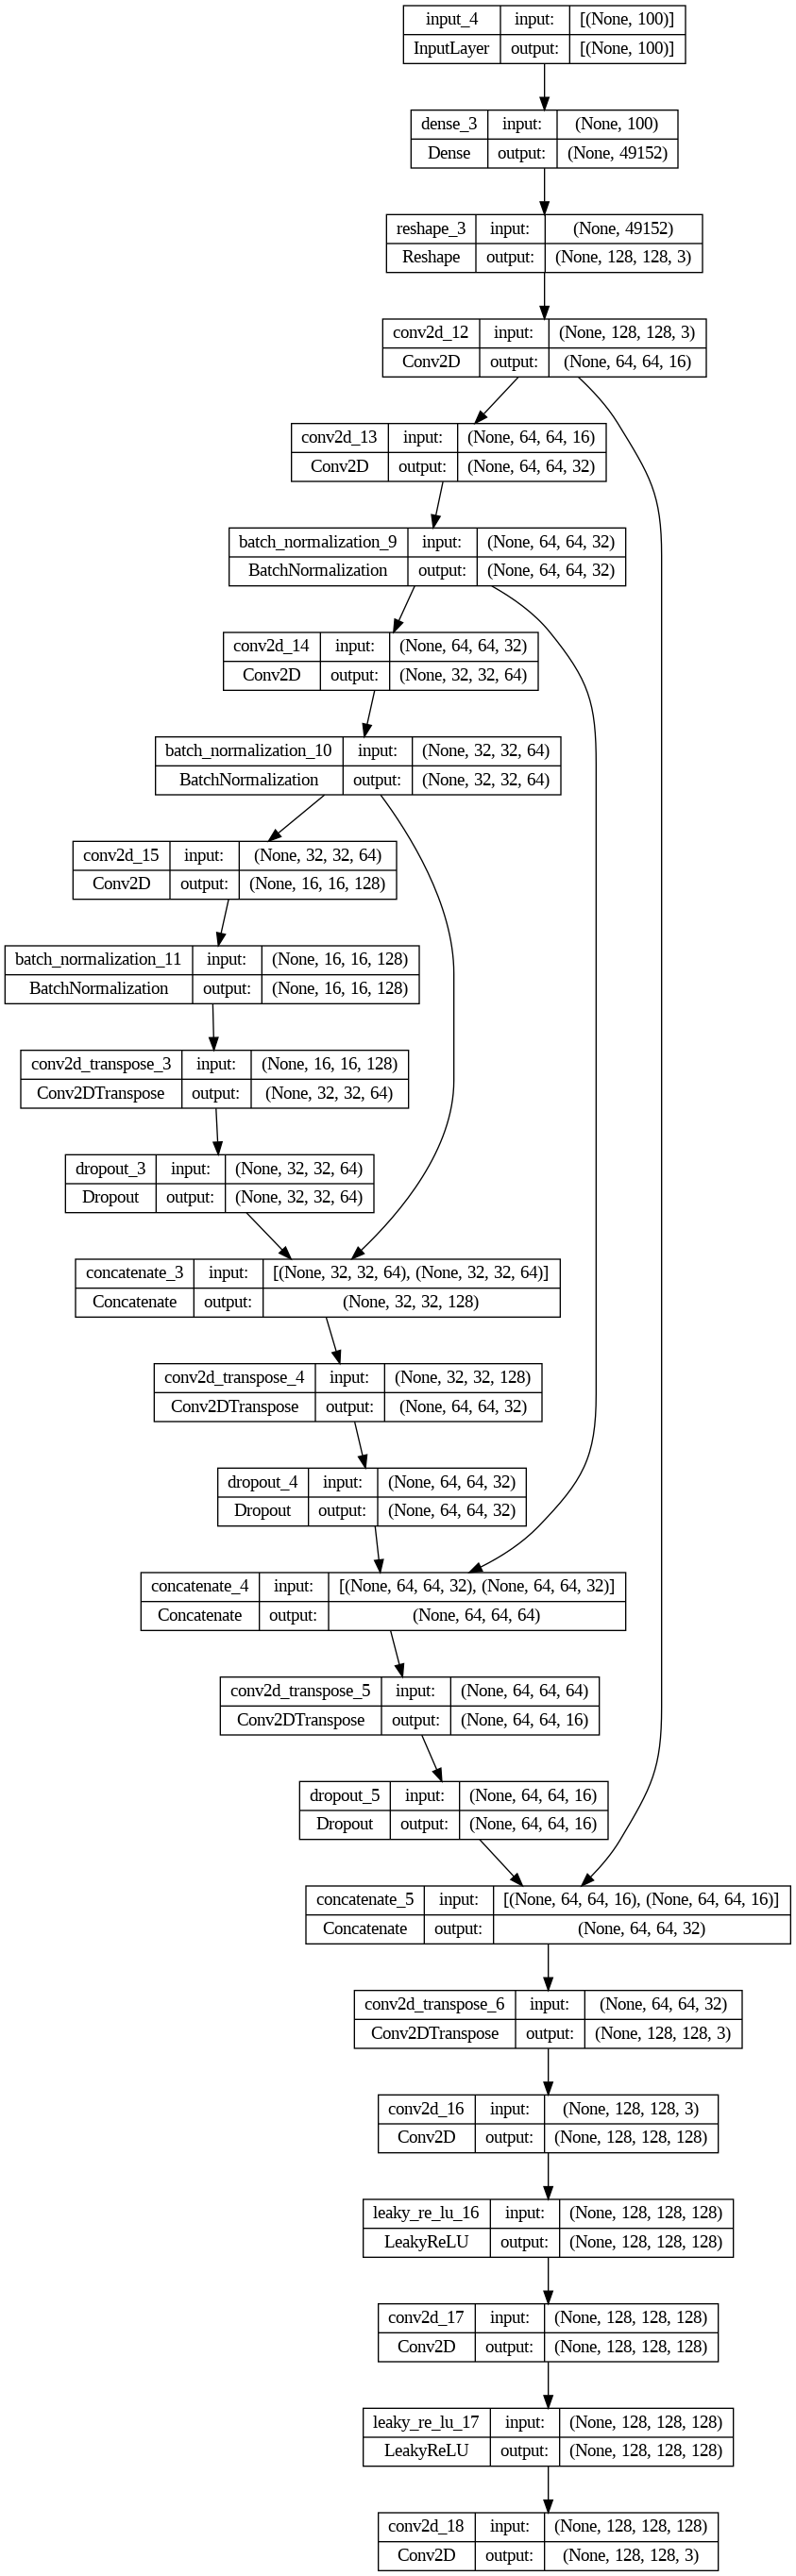

In [14]:
generator=tf.keras.models.load_model('generator_model_cut.h5')
generator.summary()
tf.keras.utils.plot_model(generator,show_shapes=True)

In [15]:
# class ConditionBatchNormalization(tf.keras.Model):
#   def __init__(self):
#     super(ConditionBatchNormalization, self).__init__()
#     self.decay = 0.5
#     self.epsilon = 1e-04
#     self.test_mean=tf.Variable(initial_value=0, trainable=False, dtype=tf.float32)
#     self.test_var=tf.Variable(initial_value=1, trainable=False, dtype=tf.float32)

#   def build(self, input_shape):
#     self.num_channels=input_shape[0][-1]
#     self.beta_mapping=tf.keras.layers.Dense(self.num_channels)
#     self.gamma_mapping=tf.keras.layers.Dense(self.num_channels)
    
#   def call(self, x, training=None):
#     #Generate beta, gamma
#     x, conditions = x
#     beta = self.beta_mapping(conditions)
#     gamma = self.gamma_mapping(conditions)

#     beta = tf.reshape(beta, shape=[-1, 1, 1, self.num_channels])
#     gamma = tf.reshape(gamma, shape=[-1, 1, 1, self.num_channels])
#     if training:
#         #Calculate mean and varience of X.
#         batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
#         #Calculate parameters for test set 
#         self.test_mean = self.test_mean * self.decay + batch_mean * (1 - self.decay)
#         self.test_var = self.test_var * self.decay + batch_var * (1 - self.decay)

#         return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, self.epsilon)
#     else:
#         return tf.nn.batch_normalization(x, self.test_mean, self.test_var, beta, gamma, self.epsilon)

# class SelfAttention(tf.keras.Model):
#   def __init__(self):
#     super(SelfAttention, self).__init__()

#   def build(self, input_shape):
#     self.num_channels=input_shape[-1]
#     self.hw = input_shape[1]*input_shape[2]
#     self.conv_f=tf.keras.layers.Conv2D(self.num_channels // 4, 1)
#     self.conv_g=tf.keras.layers.Conv2D(self.num_channels // 4, 1)
#     self.conv_h=tf.keras.layers.Conv2D(self.num_channels//2, 1)
#     self.conv_o=tf.keras.layers.Conv2D(self.num_channels, 1)

#   def call(self, x):
#     bs = x.shape[0]
#     f = self.conv_f(x)  # [bs, h, w, c']
#     g = self.conv_g(x)  # [bs, h, w, c']
#     h = self.conv_h(x)  # [bs, h, w, c]

#     f=tf.keras.layers.Reshape([self.hw, f.shape[-1]])(f)
#     g=tf.keras.layers.Reshape([self.hw, g.shape[-1]])(g)
#     h=tf.keras.layers.Reshape([self.hw, h.shape[-1]])(h)
#     # N = h * w
#     s = tf.matmul(g, f, transpose_b=True)  # # [bs, N, N]
#     beta = tf.nn.softmax(s)  # attention map

#     o = tf.matmul(beta, h)  # [bs, N, C]
#     o = tf.keras.layers.Reshape([x.shape[1], x.shape[2], self.num_channels//2])(o)
#     o = self.conv_o(o)
#       # [bs, h, w, C]
#     return x + o

In [16]:
latent_dim=100
num_img=10
random_latent_vectors = tf.random.normal(shape=(100, latent_dim))
img=generator.predict(random_latent_vectors,batch_size=10,steps=1)
# img=tf.keras.backend.eval(img)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 13s 13s/step


(10, 128, 128, 3)


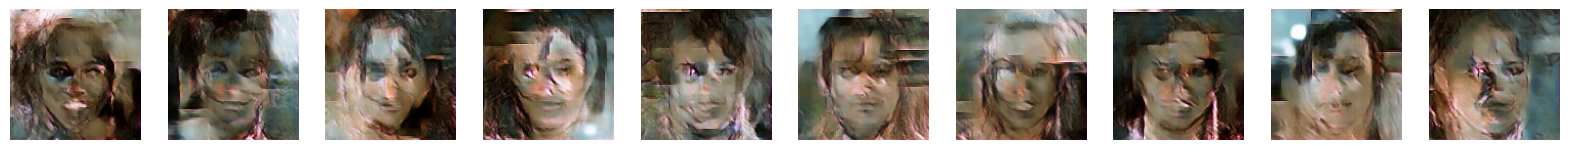

In [17]:
# img=tf.keras.backend.eval(img)

print(img.shape)
# img = img.eval(session=tf.compat.v1.Session())
fig=plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(10,10,i + 1)
    image1 = tf.keras.preprocessing.image.array_to_img(np.array(img[i]))
    plt.imshow(image1)
    plt.axis('off')
plt.show()
# print(discriminator({'image':img}).numpy())

In [18]:
def resnet_block(input,filter_size):
  conv=Conv2D(filter_size,(3,3),kernel_initializer=HeNormal(),padding='same')(input)
  conv=BatchNormalization()(conv)
  # conv=LeakyReLU()(conv)
  # conv=InstanceNormalization()(conv)
  conv=Dropout(0.4)(conv)
  conv=Conv2D(filter_size,(3,3),kernel_initializer=HeNormal(),padding='same')(conv)
  conv=BatchNormalization()(conv)
  # conv=LeakyReLU()(conv)
  # conv=InstanceNormalization()(conv)
  conv=Dropout(0.4)(conv)
  conv=add([input,conv])
  return conv

def make_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same', input_shape=(128,128,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  # opt = Adam(lr=0.0002, beta_1=0.5)
  # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# discriminator=make_discriminator()
# discriminator.summary()
# tf.keras.utils.plot_model(discriminator,show_shapes=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       1

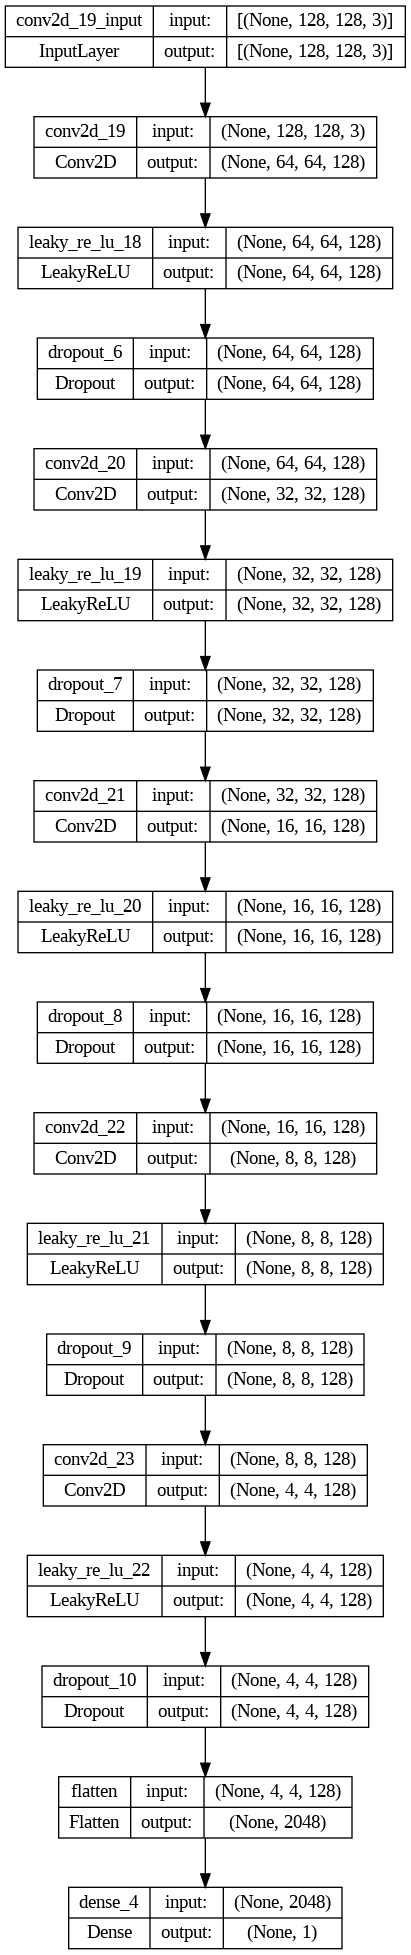

In [19]:
discriminator=tf.keras.models.load_model('discriminator_model_cut.h5')
discriminator.summary()
tf.keras.utils.plot_model(discriminator,show_shapes=True)


In [20]:
ypred_bottleneck=discriminator.predict(img)


1/1 [==============================] - 0s 245ms/step


In [21]:
ypred_bottleneck

array([[0.00093939],
       [0.00042729],
       [0.00048432],
       [0.0001275 ],
       [0.00087589],
       [0.00159202],
       [0.00066002],
       [0.00106551],
       [0.00386253],
       [0.00091875]], dtype=float32)

In [22]:
from keras.losses import BinaryCrossentropy
generator_optimizer = tf.keras.optimizers.Adam(0.00005)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

generator_loss=BinaryCrossentropy(from_logits=True)
discriminator_loss=BinaryCrossentropy(from_logits=True)

In [23]:
from matplotlib.lines import Real

def preprocess_image1(image):
    return image


def augumentation(real,fake):

  train_ds_one = (
      tf.data.Dataset.from_tensor_slices(real)
      .shuffle(1024)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )
  train_ds_two = (
      tf.data.Dataset.from_tensor_slices(fake)
      .shuffle(1024)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )

  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )
  return train_ds_cmu

In [24]:
class GAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.generator=generator
    self.discriminator=discriminator

  def compile(self,generator_optimizer,discriminator_optimizer,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.generator_optimizer=generator_optimizer
    self.discriminator_optimizer=discriminator_optimizer
    pass
  def train_step(self,images):
    noise=tf.random.normal((BATCH_SIZE,100))

    with tf.GradientTape() as g_tape,tf.GradientTape() as d_tape:
      generated_image=self.generator(noise,training=True)
      
      train_ds_cmu=augumentation(images,generated_image)
      tf.config.run_functions_eagerly(True)
      augumented_images = train_ds_cmu.as_numpy_iterator()
      augumented_images = np.concatenate([batch for batch in augumented_images], axis=0)

      ypred_real_decoder=self.discriminator(augumented_images,training=True)
      ypred_fake_decoder=self.discriminator(generated_image,training=True)
      ypred_gen_decoder=self.discriminator(generated_image,training=False)


      # real_loss=discriminator_loss(tf.ones_like(ypred_real_encoder),ypred_real_encoder)+discriminator_loss(tf.ones_like(ypred_real_decoder),ypred_real_decoder)
      # fake_loss=discriminator_loss(tf.zeros_like(ypred_fake_encoder),ypred_fake_encoder)+discriminator_loss(tf.zeros_like(ypred_fake_decoder),ypred_fake_decoder)
      
      real_loss=discriminator_loss(tf.ones_like(ypred_real_decoder),ypred_real_decoder)
      fake_loss=discriminator_loss(tf.zeros_like(ypred_fake_decoder),ypred_fake_decoder)
      total_d_loss=(real_loss+fake_loss)

      # total_g_loss=generator_loss(tf.ones_like(ypred_gen_encoder),ypred_gen_encoder)+generator_loss(tf.ones_like(ypred_gen_decoder),ypred_gen_decoder)
      total_g_loss=(generator_loss(tf.ones_like(ypred_gen_decoder),ypred_gen_decoder))



    ggrad=g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    dgrad=d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(ggrad,self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))




    return {"d_loss:":total_d_loss,"g_loss:":total_g_loss}




In [25]:
GAN_model=GAN(generator,discriminator)
GAN_model.compile(generator_optimizer,discriminator_optimizer)

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
# reduce_lr_disc = ReduceLROnPlateau(monitor='d_loss:', factor=0.1, patience=3, min_lr=0.01)
# reduce_lr_gen = ReduceLROnPlateau(monitor='g_loss:', factor=0.1, patience=3, min_lr=0.01)
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=(100)):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # d_image=self.model.discriminator(generated_images)
#         disc_images=self.model.discriminator(generated_images)
        generated_images *= 255
#         disc_images*=255
        generated_images.numpy()
#         disc_images.numpy()

        for i in range(self.num_img):
            gen_img = array_to_img(generated_images[i])
#             disc_img = array_to_img(disc_images[i])
            gen_img.save(os.path.join('images4', f'generated_img_{epoch+1}_{i}.png'))
            # self.model.GAN_model.save('gan4.h5')
            self.model.generator.save('generator_model_cut.h5')
            self.model.discriminator.save('discriminator_model_cut.h5')
#             new_image1 = Image.new('RGB',(2*128, 128), (250,250,250))
#             new_image1.paste(gen_img,(0,0))
#             new_image1.paste(disc_img,(128,0))
#             new_image1.save(os.path.join('images2', f'generated_img_{epoch}_{i}.png'))

            
            
        def on_train_end(self, logs=None):
          self.model.save_pretrained('images4')
          self.generator.save('generator_model_cut.h5')
          self.discriminator.save('discriminator_model_cut.h5')
        

In [ ]:
epochs=500
BATCH_SIZE=64
Model_=GAN_model.fit(new_image,epochs=epochs,batch_size=BATCH_SIZE,callbacks=[ModelMonitor()])

Epoch 1/500


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - ETA: 0s - d_loss:: 1.2209 - g_loss:: 5.4177

16/16 [==============================] - 47s 2s/step - d_loss:: 1.2597 - g_loss:: 5.3530
Epoch 2/500
16/16 [==============================] - ETA: 0s - d_loss:: 1.0976 - g_loss:: 4.3745

16/16 [==============================] - 29s 2s/step - d_loss:: 1.0945 - g_loss:: 4.3900
Epoch 3/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6882 - g_loss:: 4.7641

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6975 - g_loss:: 4.7812
Epoch 4/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7836 - g_loss:: 5.3970

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7972 - g_loss:: 5.3939
Epoch 5/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6092 - g_loss:: 4.9488

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6184 - g_loss:: 4.9716
Epoch 6/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.8534 - g_loss:: 4.2556

16/16 [==============================] - 29s 2s/step - d_loss:: 0.8444 - g_loss:: 4.2427
Epoch 7/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5933 - g_loss:: 4.7112

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6127 - g_loss:: 4.7624
Epoch 8/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5342 - g_loss:: 5.7201

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5332 - g_loss:: 5.7539
Epoch 9/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5143 - g_loss:: 5.8417

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5112 - g_loss:: 5.8361
Epoch 10/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3638 - g_loss:: 5.8884

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3706 - g_loss:: 5.8804
Epoch 11/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5371 - g_loss:: 5.9235

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5344 - g_loss:: 5.9403
Epoch 12/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.8158 - g_loss:: 5.0308

16/16 [==============================] - 29s 2s/step - d_loss:: 0.8302 - g_loss:: 5.0348
Epoch 13/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6288 - g_loss:: 4.8719

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6336 - g_loss:: 4.9173
Epoch 14/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4619 - g_loss:: 6.0055

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4612 - g_loss:: 6.0248
Epoch 15/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5734 - g_loss:: 5.5893

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5822 - g_loss:: 5.5220
Epoch 16/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6087 - g_loss:: 4.9393

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6050 - g_loss:: 4.9404
Epoch 17/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6015 - g_loss:: 5.3175

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6106 - g_loss:: 5.3437
Epoch 18/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7581 - g_loss:: 4.6594

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7642 - g_loss:: 4.6405
Epoch 19/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6555 - g_loss:: 4.2031

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6418 - g_loss:: 4.2003
Epoch 20/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3853 - g_loss:: 4.6282

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3800 - g_loss:: 4.6582
Epoch 21/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5548 - g_loss:: 5.7216

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5556 - g_loss:: 5.7471
Epoch 22/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7793 - g_loss:: 5.4082

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7608 - g_loss:: 5.3906
Epoch 23/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6705 - g_loss:: 5.4793

16/16 [==============================] - 29s 2s/step - d_loss:: 0.7203 - g_loss:: 5.4518
Epoch 24/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5882 - g_loss:: 4.2847

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5704 - g_loss:: 4.2658
Epoch 25/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5773 - g_loss:: 4.4635

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6024 - g_loss:: 4.4605
Epoch 26/500
16/16 [==============================] - ETA: 0s - d_loss:: 1.0759 - g_loss:: 3.7968

16/16 [==============================] - 29s 2s/step - d_loss:: 1.0660 - g_loss:: 3.7656
Epoch 27/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7123 - g_loss:: 3.5438

16/16 [==============================] - 29s 2s/step - d_loss:: 0.7073 - g_loss:: 3.5853
Epoch 28/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5979 - g_loss:: 4.1279

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5879 - g_loss:: 4.1437
Epoch 29/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5982 - g_loss:: 4.5257

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5932 - g_loss:: 4.5372
Epoch 30/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3855 - g_loss:: 5.1152

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3844 - g_loss:: 5.1215
Epoch 31/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4296 - g_loss:: 5.9818

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4304 - g_loss:: 5.9842
Epoch 32/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4026 - g_loss:: 6.5695

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4139 - g_loss:: 6.5468
Epoch 33/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5514 - g_loss:: 6.4205

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5557 - g_loss:: 6.3810
Epoch 34/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6242 - g_loss:: 5.8592

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6280 - g_loss:: 5.8266
Epoch 35/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4070 - g_loss:: 6.0275

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4026 - g_loss:: 6.0378
Epoch 36/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4700 - g_loss:: 6.4134

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4786 - g_loss:: 6.3856
Epoch 37/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5210 - g_loss:: 5.8753

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5085 - g_loss:: 5.8442
Epoch 38/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4618 - g_loss:: 5.2293

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4597 - g_loss:: 5.2075
Epoch 39/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5549 - g_loss:: 5.0045

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5649 - g_loss:: 5.0256
Epoch 40/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6966 - g_loss:: 4.8897

16/16 [==============================] - 31s 2s/step - d_loss:: 0.6835 - g_loss:: 4.9190
Epoch 41/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5871 - g_loss:: 4.5441

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5848 - g_loss:: 4.5003
Epoch 42/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4429 - g_loss:: 4.6036

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4362 - g_loss:: 4.6488
Epoch 43/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5250 - g_loss:: 5.4105

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5429 - g_loss:: 5.4399
Epoch 44/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6121 - g_loss:: 5.6299

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6218 - g_loss:: 5.5996
Epoch 45/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4999 - g_loss:: 5.6092

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4979 - g_loss:: 5.5920
Epoch 46/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3918 - g_loss:: 5.6796

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3970 - g_loss:: 5.6918
Epoch 47/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4861 - g_loss:: 5.8448

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5048 - g_loss:: 5.8541
Epoch 48/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6150 - g_loss:: 5.2599

16/16 [==============================] - 31s 2s/step - d_loss:: 0.6095 - g_loss:: 5.2491
Epoch 49/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4491 - g_loss:: 5.3368

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4450 - g_loss:: 5.3349
Epoch 50/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3832 - g_loss:: 5.8309

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3708 - g_loss:: 5.8432
Epoch 51/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4895 - g_loss:: 6.0680

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5073 - g_loss:: 6.0510
Epoch 52/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7081 - g_loss:: 5.9418

16/16 [==============================] - 29s 2s/step - d_loss:: 0.7115 - g_loss:: 5.8943
Epoch 53/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3901 - g_loss:: 5.9560

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3861 - g_loss:: 5.9690
Epoch 54/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5406 - g_loss:: 5.7689

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5428 - g_loss:: 5.7438
Epoch 55/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3429 - g_loss:: 5.4112

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3462 - g_loss:: 5.4205
Epoch 56/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7683 - g_loss:: 4.9975

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7552 - g_loss:: 4.9622
Epoch 57/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3241 - g_loss:: 4.7112

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3167 - g_loss:: 4.7618
Epoch 58/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3777 - g_loss:: 5.9640

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3941 - g_loss:: 5.9867
Epoch 59/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.8001 - g_loss:: 4.9570

16/16 [==============================] - 29s 2s/step - d_loss:: 0.7706 - g_loss:: 4.9633
Epoch 60/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2149 - g_loss:: 4.7409

16/16 [==============================] - 29s 2s/step - d_loss:: 0.2152 - g_loss:: 4.7561
Epoch 61/500
16/16 [==============================] - ETA: 0s - d_loss:: 1.1027 - g_loss:: 4.7275

16/16 [==============================] - 30s 2s/step - d_loss:: 1.0698 - g_loss:: 4.6707
Epoch 62/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4047 - g_loss:: 4.1274

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4082 - g_loss:: 4.1610
Epoch 63/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6746 - g_loss:: 4.6823

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6805 - g_loss:: 4.6457
Epoch 64/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4520 - g_loss:: 4.4815

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4550 - g_loss:: 4.4832
Epoch 65/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6952 - g_loss:: 4.7501

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7224 - g_loss:: 4.7506
Epoch 66/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5492 - g_loss:: 4.5445

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5436 - g_loss:: 4.5662
Epoch 67/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5163 - g_loss:: 4.9566

16/16 [==============================] - 31s 2s/step - d_loss:: 0.5305 - g_loss:: 4.9639
Epoch 68/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6272 - g_loss:: 4.9945

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6090 - g_loss:: 4.9996
Epoch 69/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4390 - g_loss:: 5.5061

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4436 - g_loss:: 5.4916
Epoch 70/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6472 - g_loss:: 5.3816

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6561 - g_loss:: 5.3666
Epoch 71/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5604 - g_loss:: 5.0796

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5562 - g_loss:: 5.0855
Epoch 72/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4365 - g_loss:: 5.1825

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4350 - g_loss:: 5.2218
Epoch 73/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4445 - g_loss:: 5.6327

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4439 - g_loss:: 5.6276
Epoch 74/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3888 - g_loss:: 5.6740

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3757 - g_loss:: 5.6771
Epoch 75/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2526 - g_loss:: 6.1594

16/16 [==============================] - 31s 2s/step - d_loss:: 0.2442 - g_loss:: 6.1943
Epoch 76/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3877 - g_loss:: 6.6532

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4010 - g_loss:: 6.6632
Epoch 77/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4354 - g_loss:: 6.9989

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4408 - g_loss:: 6.9912
Epoch 78/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6853 - g_loss:: 6.4829

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7208 - g_loss:: 6.4103
Epoch 79/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6279 - g_loss:: 4.8541

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6337 - g_loss:: 4.8492
Epoch 80/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5168 - g_loss:: 5.0181

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5144 - g_loss:: 5.0251
Epoch 81/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4111 - g_loss:: 5.5811

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4053 - g_loss:: 5.5895
Epoch 82/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3166 - g_loss:: 6.3692

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3128 - g_loss:: 6.4010
Epoch 83/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7041 - g_loss:: 6.4473

16/16 [==============================] - 29s 2s/step - d_loss:: 0.7103 - g_loss:: 6.3801
Epoch 84/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3910 - g_loss:: 5.6815

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4017 - g_loss:: 5.6395
Epoch 85/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6026 - g_loss:: 5.2715

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6038 - g_loss:: 5.2236
Epoch 86/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.7245 - g_loss:: 4.2586

16/16 [==============================] - 30s 2s/step - d_loss:: 0.7139 - g_loss:: 4.2295
Epoch 87/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4080 - g_loss:: 4.5518

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4057 - g_loss:: 4.5776
Epoch 88/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4125 - g_loss:: 5.2969

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4127 - g_loss:: 5.2851
Epoch 89/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6089 - g_loss:: 5.1631

16/16 [==============================] - 29s 2s/step - d_loss:: 0.6156 - g_loss:: 5.1781
Epoch 90/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5448 - g_loss:: 5.2385

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5367 - g_loss:: 5.2766
Epoch 91/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5658 - g_loss:: 5.7163

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5606 - g_loss:: 5.6617
Epoch 92/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5284 - g_loss:: 5.1925

16/16 [==============================] - 31s 2s/step - d_loss:: 0.5272 - g_loss:: 5.1918
Epoch 93/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5192 - g_loss:: 5.3746

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5139 - g_loss:: 5.3690
Epoch 94/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3953 - g_loss:: 5.2930

16/16 [==============================] - 31s 2s/step - d_loss:: 0.3897 - g_loss:: 5.3140
Epoch 95/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3804 - g_loss:: 5.4299

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3770 - g_loss:: 5.4604
Epoch 96/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3750 - g_loss:: 5.8044

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3885 - g_loss:: 5.8180
Epoch 97/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5548 - g_loss:: 5.9038

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5548 - g_loss:: 5.9036
Epoch 98/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4690 - g_loss:: 6.3820

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4606 - g_loss:: 6.4180
Epoch 99/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4905 - g_loss:: 6.2475

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4861 - g_loss:: 6.2323
Epoch 100/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5363 - g_loss:: 5.7627

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5250 - g_loss:: 5.7625
Epoch 101/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5481 - g_loss:: 5.4832

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5529 - g_loss:: 5.4735
Epoch 102/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5261 - g_loss:: 5.2090

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5174 - g_loss:: 5.2183
Epoch 103/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4900 - g_loss:: 5.3184

16/16 [==============================] - 32s 2s/step - d_loss:: 0.4876 - g_loss:: 5.3029
Epoch 104/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4339 - g_loss:: 5.4332

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4343 - g_loss:: 5.4289
Epoch 105/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3447 - g_loss:: 5.9682

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3385 - g_loss:: 5.9951
Epoch 106/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3949 - g_loss:: 6.7499

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4049 - g_loss:: 6.7609
Epoch 107/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4219 - g_loss:: 6.6945

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4230 - g_loss:: 6.6991
Epoch 108/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4527 - g_loss:: 6.4500

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4575 - g_loss:: 6.4627
Epoch 109/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3979 - g_loss:: 6.2119

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4027 - g_loss:: 6.1922
Epoch 110/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4077 - g_loss:: 6.5642

16/16 [==============================] - 31s 2s/step - d_loss:: 0.3953 - g_loss:: 6.5893
Epoch 111/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3144 - g_loss:: 7.3766

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3147 - g_loss:: 7.3521
Epoch 112/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5422 - g_loss:: 7.0977

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5404 - g_loss:: 7.0737
Epoch 113/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4868 - g_loss:: 6.5575

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4738 - g_loss:: 6.5632
Epoch 114/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5530 - g_loss:: 6.1054

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5422 - g_loss:: 6.0832
Epoch 115/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4491 - g_loss:: 5.9260

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4448 - g_loss:: 5.9500
Epoch 116/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4929 - g_loss:: 5.9247

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4944 - g_loss:: 5.9091
Epoch 117/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5040 - g_loss:: 5.9316

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4940 - g_loss:: 5.9516
Epoch 118/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4331 - g_loss:: 5.8653

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4358 - g_loss:: 5.8279
Epoch 119/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4691 - g_loss:: 5.8363

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4669 - g_loss:: 5.8628
Epoch 120/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6126 - g_loss:: 5.7522

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6131 - g_loss:: 5.7626
Epoch 121/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6346 - g_loss:: 5.1231

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6231 - g_loss:: 5.0989
Epoch 122/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5140 - g_loss:: 4.8030

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5053 - g_loss:: 4.7987
Epoch 123/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5143 - g_loss:: 5.1586

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5096 - g_loss:: 5.1795
Epoch 124/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3856 - g_loss:: 5.5992

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3832 - g_loss:: 5.6118
Epoch 125/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4116 - g_loss:: 5.8544

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4132 - g_loss:: 5.8777
Epoch 126/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5608 - g_loss:: 5.7934

16/16 [==============================] - 31s 2s/step - d_loss:: 0.5513 - g_loss:: 5.7899
Epoch 127/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4746 - g_loss:: 5.6219

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4648 - g_loss:: 5.6246
Epoch 128/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4426 - g_loss:: 5.9200

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4514 - g_loss:: 5.9255
Epoch 129/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4169 - g_loss:: 5.9100

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4204 - g_loss:: 5.9246
Epoch 130/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5258 - g_loss:: 5.6694

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5240 - g_loss:: 5.6865
Epoch 131/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5571 - g_loss:: 5.7604

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5457 - g_loss:: 5.7496
Epoch 132/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3380 - g_loss:: 5.8368

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3466 - g_loss:: 5.8526
Epoch 133/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3525 - g_loss:: 6.0979

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3671 - g_loss:: 6.1040
Epoch 134/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4984 - g_loss:: 6.2241

16/16 [==============================] - 31s 2s/step - d_loss:: 0.5143 - g_loss:: 6.2145
Epoch 135/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3732 - g_loss:: 6.0826

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3700 - g_loss:: 6.1010
Epoch 136/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2672 - g_loss:: 6.8891

16/16 [==============================] - 30s 2s/step - d_loss:: 0.2598 - g_loss:: 6.9009
Epoch 137/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3580 - g_loss:: 7.0062

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3696 - g_loss:: 6.9487
Epoch 138/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6848 - g_loss:: 6.7624

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6926 - g_loss:: 6.7189
Epoch 139/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5941 - g_loss:: 5.9865

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5874 - g_loss:: 5.9646
Epoch 140/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4071 - g_loss:: 5.4463

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4001 - g_loss:: 5.4142
Epoch 141/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4354 - g_loss:: 4.8983

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4301 - g_loss:: 4.9094
Epoch 142/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3731 - g_loss:: 5.4736

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3774 - g_loss:: 5.4873
Epoch 143/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4113 - g_loss:: 6.1519

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4112 - g_loss:: 6.1511
Epoch 144/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2664 - g_loss:: 6.2497

16/16 [==============================] - 29s 2s/step - d_loss:: 0.2603 - g_loss:: 6.2795
Epoch 145/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3978 - g_loss:: 6.4996

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4021 - g_loss:: 6.5012
Epoch 146/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3190 - g_loss:: 6.7726

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3103 - g_loss:: 6.7921
Epoch 147/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4663 - g_loss:: 7.2174

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4702 - g_loss:: 7.2029
Epoch 148/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6265 - g_loss:: 5.8099

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6056 - g_loss:: 5.8133
Epoch 149/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2870 - g_loss:: 5.9286

16/16 [==============================] - 30s 2s/step - d_loss:: 0.2920 - g_loss:: 5.9285
Epoch 150/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4993 - g_loss:: 6.2932

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5119 - g_loss:: 6.3029
Epoch 151/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3390 - g_loss:: 6.9054

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3350 - g_loss:: 6.9291
Epoch 152/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4881 - g_loss:: 6.1995

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4817 - g_loss:: 6.1936
Epoch 153/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4230 - g_loss:: 6.0070

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4112 - g_loss:: 6.0397
Epoch 154/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5072 - g_loss:: 6.2125

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5182 - g_loss:: 6.1781
Epoch 155/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4434 - g_loss:: 6.2742

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4461 - g_loss:: 6.2928
Epoch 156/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6469 - g_loss:: 5.4581

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6355 - g_loss:: 5.4102
Epoch 157/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3865 - g_loss:: 4.7527

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3828 - g_loss:: 4.7735
Epoch 158/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3600 - g_loss:: 6.0629

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3644 - g_loss:: 6.0626
Epoch 159/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6279 - g_loss:: 6.0498

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6265 - g_loss:: 6.0186
Epoch 160/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3554 - g_loss:: 5.4589

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3480 - g_loss:: 5.4751
Epoch 161/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4080 - g_loss:: 5.9688

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4433 - g_loss:: 6.0279
Epoch 162/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6730 - g_loss:: 5.3118

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6447 - g_loss:: 5.2812
Epoch 163/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3357 - g_loss:: 5.3822

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3349 - g_loss:: 5.4345
Epoch 164/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3114 - g_loss:: 6.4685

16/16 [==============================] - 29s 2s/step - d_loss:: 0.2992 - g_loss:: 6.5224
Epoch 165/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3365 - g_loss:: 6.8806

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3357 - g_loss:: 6.8831
Epoch 166/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5082 - g_loss:: 6.0783

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5033 - g_loss:: 6.0586
Epoch 167/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6217 - g_loss:: 5.4627

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6155 - g_loss:: 5.4546
Epoch 168/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4212 - g_loss:: 5.1593

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4280 - g_loss:: 5.1597
Epoch 169/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4327 - g_loss:: 5.3418

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4327 - g_loss:: 5.3531
Epoch 170/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4364 - g_loss:: 5.1062

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4344 - g_loss:: 5.1102
Epoch 171/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4409 - g_loss:: 5.3794

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4409 - g_loss:: 5.3899
Epoch 172/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4631 - g_loss:: 5.9119

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4660 - g_loss:: 5.9211
Epoch 173/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4314 - g_loss:: 6.1213

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4188 - g_loss:: 6.1271
Epoch 174/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4667 - g_loss:: 6.2613

16/16 [==============================] - 31s 2s/step - d_loss:: 0.4736 - g_loss:: 6.2723
Epoch 175/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4009 - g_loss:: 6.2241

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3939 - g_loss:: 6.2284
Epoch 176/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3050 - g_loss:: 6.6547

16/16 [==============================] - 32s 2s/step - d_loss:: 0.3094 - g_loss:: 6.6658
Epoch 177/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4459 - g_loss:: 6.8982

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4422 - g_loss:: 6.8696
Epoch 178/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4585 - g_loss:: 6.2636

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4484 - g_loss:: 6.2679
Epoch 179/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2697 - g_loss:: 6.4138

16/16 [==============================] - 31s 2s/step - d_loss:: 0.2740 - g_loss:: 6.4231
Epoch 180/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3897 - g_loss:: 6.8983

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3994 - g_loss:: 6.8992
Epoch 181/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3859 - g_loss:: 6.6868

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3851 - g_loss:: 6.6574
Epoch 182/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3535 - g_loss:: 6.5995

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3486 - g_loss:: 6.5996
Epoch 183/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3536 - g_loss:: 7.1404

16/16 [==============================] - 31s 2s/step - d_loss:: 0.3576 - g_loss:: 7.1532
Epoch 184/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3145 - g_loss:: 7.4993

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3303 - g_loss:: 7.5162
Epoch 185/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3053 - g_loss:: 7.5084

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3095 - g_loss:: 7.4751
Epoch 186/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4741 - g_loss:: 7.1095

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4653 - g_loss:: 7.0985
Epoch 187/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4982 - g_loss:: 6.6519

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5021 - g_loss:: 6.5938
Epoch 188/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4301 - g_loss:: 5.8757

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4220 - g_loss:: 5.8559
Epoch 189/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2241 - g_loss:: 5.9816

16/16 [==============================] - 30s 2s/step - d_loss:: 0.2224 - g_loss:: 6.0076
Epoch 190/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3034 - g_loss:: 6.6503

16/16 [==============================] - 32s 2s/step - d_loss:: 0.3087 - g_loss:: 6.6393
Epoch 191/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3837 - g_loss:: 6.6921

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3771 - g_loss:: 6.6798
Epoch 192/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4624 - g_loss:: 7.2572

16/16 [==============================] - 30s 2s/step - d_loss:: 0.4521 - g_loss:: 7.2549
Epoch 193/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3899 - g_loss:: 7.4465

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3867 - g_loss:: 7.4371
Epoch 194/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3291 - g_loss:: 6.9655

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3232 - g_loss:: 6.9696
Epoch 195/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2931 - g_loss:: 6.8387

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3065 - g_loss:: 6.8258
Epoch 196/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3582 - g_loss:: 6.9131

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3523 - g_loss:: 6.9146
Epoch 197/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3267 - g_loss:: 6.5995

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3324 - g_loss:: 6.5797
Epoch 198/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3604 - g_loss:: 6.7078

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3527 - g_loss:: 6.7165
Epoch 199/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3745 - g_loss:: 7.1900

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3635 - g_loss:: 7.2353
Epoch 200/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5650 - g_loss:: 6.9301

16/16 [==============================] - 31s 2s/step - d_loss:: 0.5555 - g_loss:: 6.9105
Epoch 201/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5079 - g_loss:: 5.7393

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5128 - g_loss:: 5.7243
Epoch 202/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4822 - g_loss:: 5.8801

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4804 - g_loss:: 5.8993
Epoch 203/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4584 - g_loss:: 6.9142

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4537 - g_loss:: 6.9142
Epoch 204/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3212 - g_loss:: 6.8729

16/16 [==============================] - 31s 2s/step - d_loss:: 0.3228 - g_loss:: 6.8459
Epoch 205/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3089 - g_loss:: 6.6639

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3111 - g_loss:: 6.6753
Epoch 206/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5864 - g_loss:: 6.4663

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5779 - g_loss:: 6.4557
Epoch 207/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3346 - g_loss:: 6.4096

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3335 - g_loss:: 6.3909
Epoch 208/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5082 - g_loss:: 6.3797

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5173 - g_loss:: 6.3826
Epoch 209/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5186 - g_loss:: 5.7502

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5161 - g_loss:: 5.7264
Epoch 210/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3980 - g_loss:: 5.4075

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4001 - g_loss:: 5.4064
Epoch 211/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3396 - g_loss:: 5.7659

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3481 - g_loss:: 5.7712
Epoch 212/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5954 - g_loss:: 5.9428

16/16 [==============================] - 30s 2s/step - d_loss:: 0.5960 - g_loss:: 5.9320
Epoch 213/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.4146 - g_loss:: 6.1478

16/16 [==============================] - 29s 2s/step - d_loss:: 0.4237 - g_loss:: 6.1579
Epoch 214/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.6174 - g_loss:: 5.4483

16/16 [==============================] - 30s 2s/step - d_loss:: 0.6247 - g_loss:: 5.4163
Epoch 215/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3489 - g_loss:: 4.9555

16/16 [==============================] - 29s 2s/step - d_loss:: 0.3399 - g_loss:: 4.9940
Epoch 216/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.2383 - g_loss:: 6.5370

16/16 [==============================] - 30s 2s/step - d_loss:: 0.2508 - g_loss:: 6.5882
Epoch 217/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.5952 - g_loss:: 6.7924

16/16 [==============================] - 29s 2s/step - d_loss:: 0.5931 - g_loss:: 6.7760
Epoch 218/500
16/16 [==============================] - ETA: 0s - d_loss:: 0.3799 - g_loss:: 6.2330

16/16 [==============================] - 30s 2s/step - d_loss:: 0.3711 - g_loss:: 6.2498
Epoch 219/500
 8/16 [==============>...............] - ETA: 13s - d_loss:: 0.3092 - g_loss:: 6.8165

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Model_.history['d_loss:'][:50])
plt.plot(Model_.history['g_loss:'][:50])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()